In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

# --- 1. Load and Prepare Data ---
try:
    df = pd.read_csv("arecanut.csv")
except FileNotFoundError:
    print("Error: 'arecanut.csv' not found. Please make sure the CSV file is in the same directory.")
    exit()

df['Price Date'] = pd.to_datetime(df['Price Date'])
df.sort_values('Price Date', inplace=True)
price_data = df[['Max Price (Rs./Quintal)']].values

# --- 2. Scale the Data ---
# LSTMs work best with data scaled between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

# --- 3. Create Training Sequences ---
# We'll use the last 30 days of data to predict the next day's price
SEQUENCE_LENGTH = 30
X, y = [], []
for i in range(len(scaled_data) - SEQUENCE_LENGTH):
    X.append(scaled_data[i:(i + SEQUENCE_LENGTH), 0])
    y.append(scaled_data[i + SEQUENCE_LENGTH, 0])

X, y = np.array(X), np.array(y)

# Reshape X to be [samples, timesteps, features] which is required for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


# --- 4. Build and Train the LSTM Model ---
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=32, verbose=1)

# --- 5. Save the Model and Scaler ---
model.save('model_adike.h5')
joblib.dump(scaler, 'scaler_adike.gz')

print("\\nTraining complete. Model saved as 'model_adike.h5' and scaler as 'scaler_adike.gz'.")

Epoch 1/100
102/102 [==============================] - 3s 10ms/step - loss: 0.0115
Epoch 2/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0040
Epoch 3/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0040
Epoch 4/100
102/102 [==============================] - 1s 11ms/step - loss: 0.0039
Epoch 5/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 6/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 7/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 8/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 9/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 10/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0039
Epoch 11/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 12/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0038
E

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/var/folders/ls/k1p_ptn500g_fx4qdb8780cc0000gp/T/ipykernel_14533/1393869712.py:36: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from current font.
  plt.tight_layout()
/Users/adityarao/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


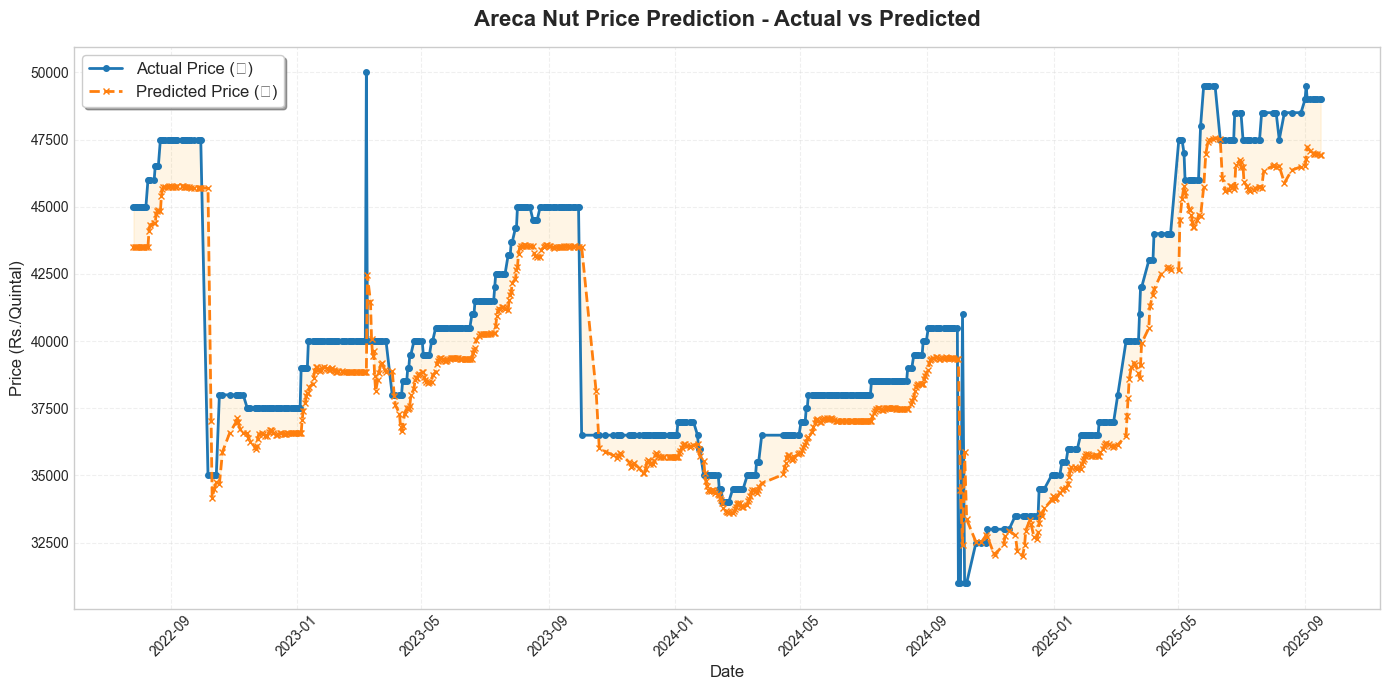

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Inverse transform predictions and true values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Prepare corresponding dates for the test set
# df['Price Date'] is your original date column
test_dates = df['Price Date'].iloc[-len(y_test_inv):]  # last n dates matching test set

plt.figure(figsize=(14,7))

# Plot actual prices
plt.plot(test_dates, y_test_inv, marker='o', markersize=4, color='#1f77b4', linewidth=2, label='Actual Price (₹)')

# Plot predicted prices
plt.plot(test_dates, y_pred_inv, marker='x', markersize=4, color='#ff7f0e', linestyle='--', linewidth=2, label='Predicted Price (₹)')

# Optional: Fill between lines for deviation visualization
plt.fill_between(test_dates, y_test_inv.ravel(), y_pred_inv.ravel(), color='orange', alpha=0.1)

# Titles and labels
plt.title('Areca Nut Price Prediction - Actual vs Predicted', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (Rs./Quintal)', fontsize=12)

# Rotate dates for readability
plt.xticks(rotation=45)

# Legend and grid
plt.legend(frameon=True, fontsize=12, loc='best', shadow=True)
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
